In [1]:
using CairoMakie, Dierckx, Optim, LinearAlgebra, QuantEcon

In [51]:
pars = (;α = 0.33, # Capital share
        β = 0.96, # Discount factor
        A = 10.0, # TFP
        γ = 2.0, # Risk aversion
        δ = 0.1, # Depreciation rate
        nk = 101, # Number of capital gridpoints
        θ = 3, # Grid expansion parameter
        lb = 1e-2, # Lower bound of capital grid
        ub = 100.0, # Upper bound of capital grid
        nz = 15, # Number of shock gridpoints
        ρ = 0.98, # Persistence of AR(1) process
        μ = 0.0, # Mean of AR(1) process
        σ = 0.01, # Var of AR(1) process
        toler = 1e-6, # Tolerance
        maxiter = 10000) # Maximum number of iterations

(α = 0.33, β = 0.96, A = 10.0, γ = 2.0, δ = 0.1, nk = 101, θ = 3, lb = 0.01, ub = 100.0, nz = 15, ρ = 0.98, μ = 0.0, σ = 0.01, toler = 1.0e-6, maxiter = 10000)

In [52]:
function utility(c)
    if pars.γ == 1.0
        return log(c)
    else
        return (c^(1-pars.γ)) / (1-pars.γ)
    end
end 

function ar1(pars)
    (; μ, ρ, σ, nz) = pars
    mc = rouwenhorst(nz, μ, ρ, σ)
    Π, Zvals = mc.p, exp.(mc.state_values)
    return Π, Zvals
end

function exp_grid(pars)
    (; nk, θ, lb, ub) = pars
    grid = LinRange(1e-4, 1.0, nk)
    expgrid = lb .+ (ub .- lb) .* grid.^θ
    return expgrid
end

function interpolate(grid, vals, pars)
    spline = Spline1D(grid, vals, k = 1, bc = "extrapolate")
    return spline
end

function production(k, z ,pars)
    (; α, δ, A) = pars
    return A * z * (k ^ α) + (1.0 - δ) * k
end

function initial_guess(grid, pars)
    (; nk, nz) = pars
    v_out = zeros(nk, nz)
    for j in 1:nz
        v_out[:,j] = j * utility.(grid)
    end
    return v_out
end

function resource_grid(kgrid, zgrid, pars)
    (; nk, nz) = pars
    Ygrid = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            Ygrid[i,j] = production(kgrid[i], zgrid[j], pars)
        end
    end
    return Ygrid
end

function capital(x, zgrid, res, pars)
    (; nk, nz) = pars
    for i in 1:nk
        for j in 1:nz
            objective_function = k -> production(k, zgrid[j], pars) - res[i,j]
            result = optimize(objective_function, 1e-2, 1000.0, Brent())
            x[i,j] = result.minimizer
        end
    end
    return x
end

function policy(pol, X, kgrid, pars)
    (; nz) = pars
    for j in 1:nz
        spl = x -> Spline1D(X[:,j], kgrid, k = 1, bc = "extrapolate")(x)
        pol[:,j] = spl.(kgrid)
    end
    return pol
end

function value(val, v, X, ystar, ygrid, kgrid, pars)
    (; nz) = pars
    for j in 1:nz
        spl = x -> Spline1D(X[:,j], ystar[:,j], k = 1, bc = "extrapolate")(x)
        spl2 = x -> Spline1D(ygrid[:,j], v[:,j], k = 1, bc = "extrapolate")(x)
        val[:,j] = spl2.(spl.(kgrid))
    end
    return val
end     

value (generic function with 1 method)

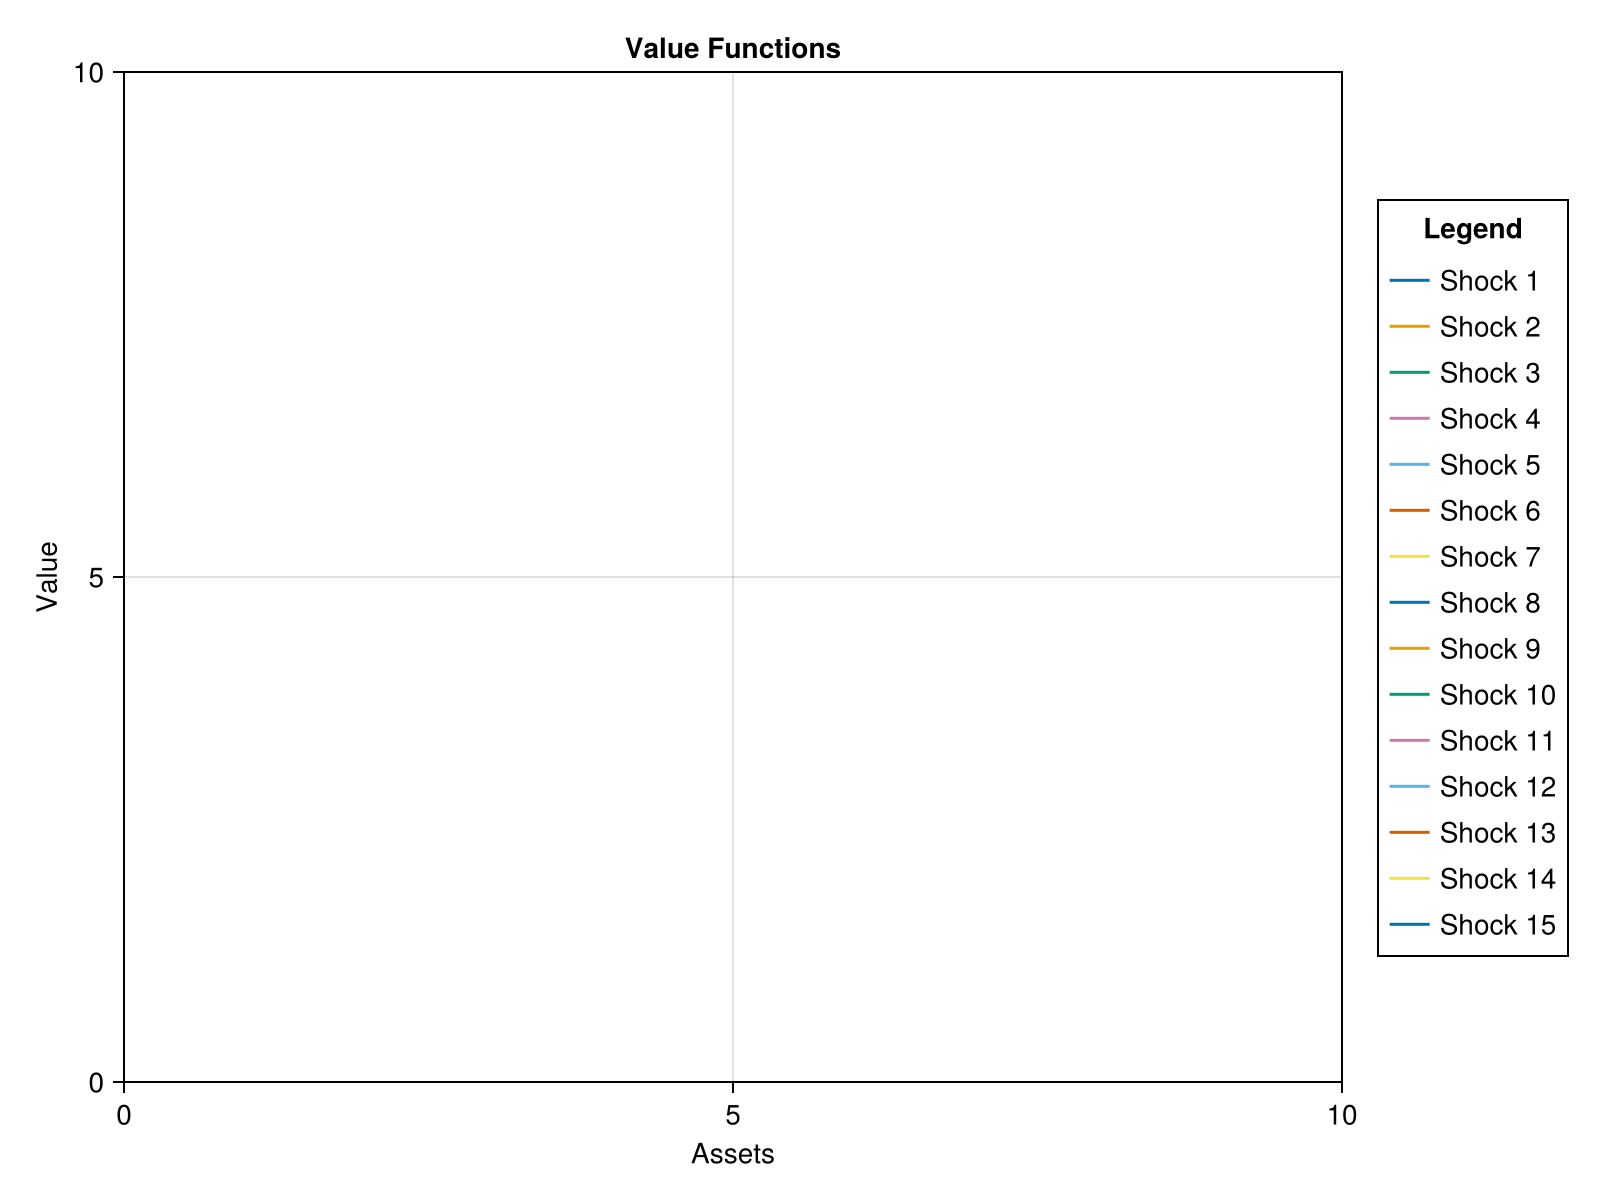

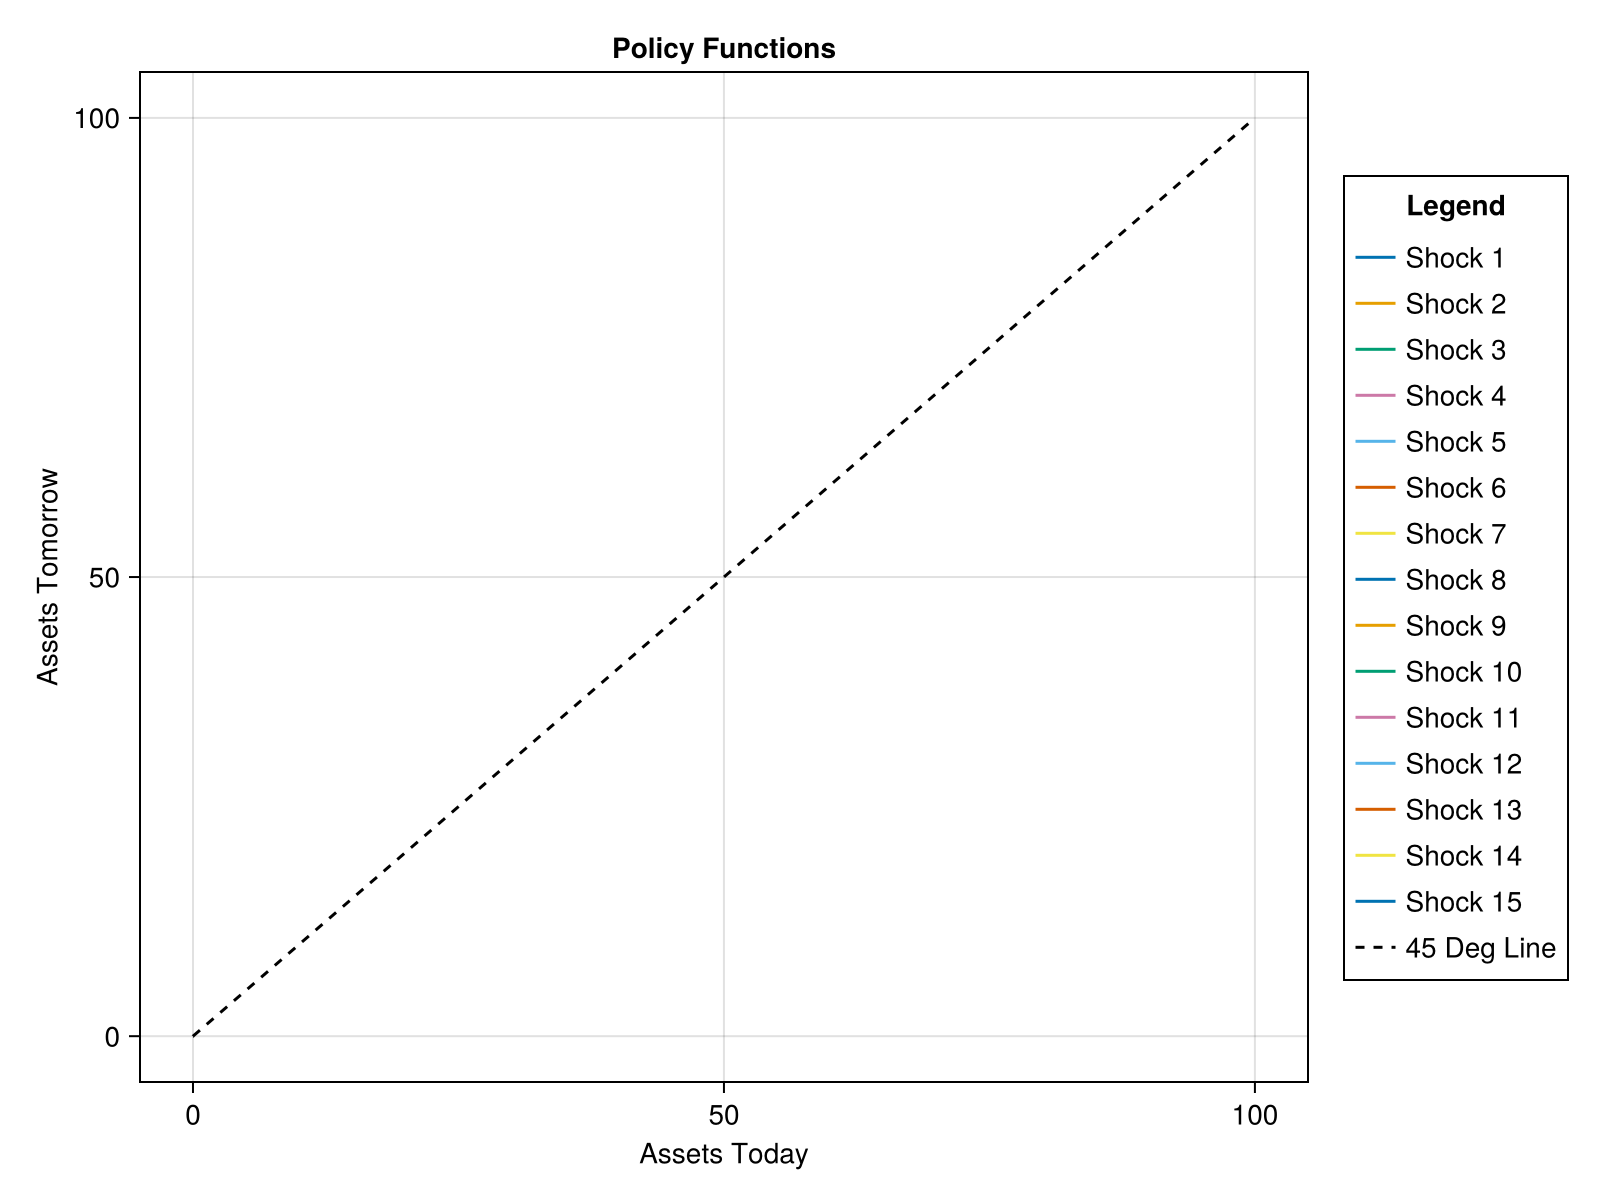

([0.01000000028889315 0.01000000028889315 … 0.01000000028889315 0.01000000028889315; 0.01000000028889315 0.01000000028889315 … 0.01000000028889315 0.01000000028889315; … ; 0.01000000028889315 0.01000000028889315 … 0.01000000028889315 0.01000000028889315; 0.01000000028889315 0.01000000028889315 … 0.01000000028889315 0.01000000028889315], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN], [NaN NaN … NaN NaN; NaN NaN … NaN NaN; … ; NaN NaN … NaN NaN; NaN NaN … NaN NaN])

In [54]:
function egm(pars)
    (; γ, nk, nz, toler, maxiter, β) = pars

    Π, Zvals = ar1(pars)
    Kvals = exp_grid(pars)

    v1 = initial_guess(exp_grid(pars), pars)
    v2 = zeros(nk, nz)
    v3 = zeros(nk, nz)
    v4 = zeros(nk, nz)

    c = zeros(nk, nz)

    derivatives = zeros(nk, nz)

    Yvals = resource_grid(Kvals, Zvals, pars)
    Ystar = zeros(nk, nz)

    Kinterpolators = Vector{Spline1D}(undef, nz)
    Yinterpolators = Vector{Spline1D}(undef, nz)

    X = zeros(nk, nz)
    Value = zeros(nk, nz)
    Policy = zeros(nk, nz)

    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end

    while ((error > toler) && (iter < maxiter))
        Kinterpolators = [interpolate(Kvals, v1[:,j], pars) for j in 1:nz]
        for (j, interpolation) in enumerate(Kinterpolators)
            derivatives[:,j] = Dierckx.derivative(interpolation, Kvals)
        end
        c = (derivatives).^(-1/γ)
        Ystar = c .+ Kvals
        v2 = utility.(c) .+ v1
        Yinterpolators = [interpolate(Ystar[:,j], v2[:,j], pars) for j in 1:nz]
        for (j, interpolation) in enumerate(Yinterpolators)
            v3[:,j] = interpolation(Yvals[:,j])
        end
        v4 = β * (v3 * Π')
        error = maximum(abs.(v4 - v1) ./ (1.0 .+ abs.(v1)))
        if iter % 50 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        v1 .= v4
        iter += 1
    end

    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    X = capital(X, Zvals, Ystar, pars)
    Value = value(Value, v1, X, Ystar, Yvals, Kvals, pars)
    Policy = policy(Policy, X, Kvals, pars)

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Kvals, Value[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Kvals, Policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Kvals, Kvals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return X, Value, Policy
end

@time begin
    test, test2, test3 = egm(pars)
end